In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import examples as eg
import numpy as np
from numpy import *
import dionysus

The circular coordinates pipeline for examining different smoothness cost-functions:

    Step 1. Getting the point cloud
    Step 2. Computing the Vietoris-Rips filtration and its cohomology
    Step 3. Selecting the Cocycle
    Step 4. First smoothing using Least Squares (Optional)
    Step 5. Second smoothing using a new cost function

## Step 1 - Getting the point cloud

In [3]:
annulus = eg.annulus_variable_d_example(n=200)
#The examples.py generates data points in form of point clouds that can be analyzed using the imported dionysus module.

## Step 2 - Computing Vietoris-Rips Complexes and Cohomology

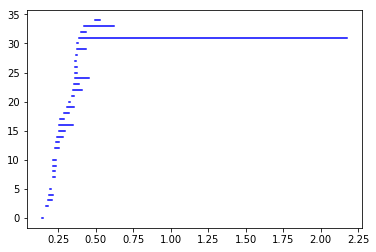

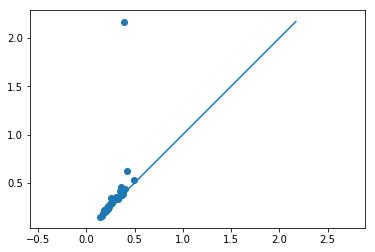

In [4]:
prime = 23 #choose the prime base for the coefficient field that we use to construct the persistence cohomology.

vr = dionysus.fill_rips(annulus, 2, 4.) #Vietoris-Rips complex
cp = dionysus.cohomology_persistence(vr, prime, True) #Create the persistent cohomology based on the chosen parameters.
dgms = dionysus.init_diagrams(cp, vr) #Calculate the persistent diagram using the designated coefficient field and complex.
dionysus.plot.plot_bars(dgms[1], show=True) 
dionysus.plot.plot_diagram(dgms[1], show=True) 
#dionysus.plot.plot_diagram(dgms[0], show=True) 
#Plot the barcode and diagrams using matplotlib incarnation within Dionysus2. This mechanism is different in Dionysus.

## Step 3 - Selecting the cocycle and visualization.

In [5]:
type(plt)

module

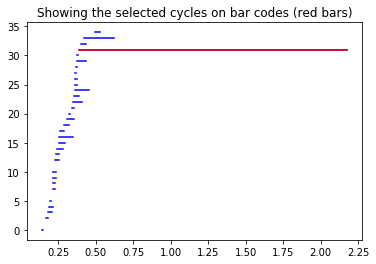

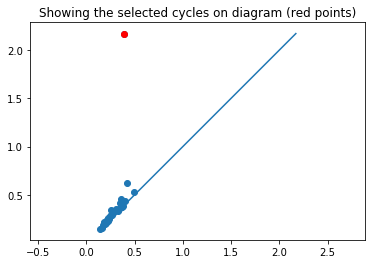

In [6]:
threshold = 1
bars = [bar for bar in dgms[1] if bar.death-bar.birth > threshold] #choosing cocycle that persist at least threshold=1.
cocycles = [cp.cocycle(bar.data) for bar in bars]
#plt is the matplotlib incarnation.

#Red highlight cocyles that persist more than threshold value on barcode, when more than one cocyles have persisted over threshold values, this plots the first one.
dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,bar.death] for bar in dgms[1] if bar.death-bar.birth > threshold][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth > threshold][0],'r')
plt.title('Showing the selected cycles on bar codes (red bars)')
plt.show()

#Red highlight ***ALL*** cocyles that persist more than threshold value on diagram.
dionysus.plot.plot_diagram(dgms[1], show=False)
Lt1 = [[point.birth,point.death] for point in dgms[1] if point.death-point.birth > threshold] 
for Lt3 in Lt1:
    #print(Lt3)
    plt.plot(Lt3[0],Lt3[1],'ro')
plt.title('Showing the selected cycles on diagram (red points)')
plt.show()


In [7]:
chosen_cocycle= cocycles[0]
chosen_bar= bars[0]

## Step 4 - First smoothing using Least Squares (Optional)

If it is computed the smoothed coefficients can be used as initial condition for the optimization code

In [8]:
vr_8 = dionysus.Filtration([s for s in vr if s.data <= max([bar.birth for bar in bars])])
coords = dionysus.smooth(vr_8, chosen_cocycle, prime)

### Visualization

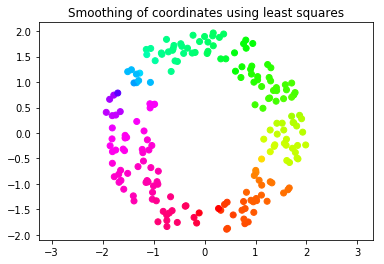

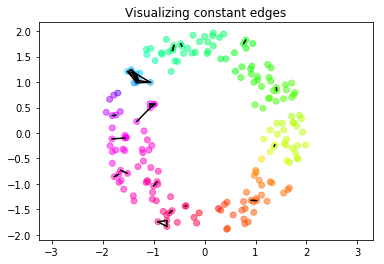

In [9]:
scatter(*annulus.T, c=coords, cmap="hsv")
plt.axis('equal')
plt.title('Smoothing of coordinates using least squares')
plt.show()

toll = 1e-5
p,val = (chosen_bar,coords)
edges_costant = []
thr = p.birth # i want to check all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(val[s[0]]-val[s[1]]) <= toll:
        edges_costant.append([annulus[s[0],:],annulus[s[1],:]])
edges_costant = np.array(edges_costant)        
scatter(*annulus.T, c=val, cmap="hsv", alpha=.5)
plot(*edges_costant.T, c='k')
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()

## Step 5 - Second smoothing using a new cost function

In [56]:
import utils
l2_cocycle,f,bdry = utils.optimizer_inputs(vr, bars, chosen_cocycle, coords, prime)

In [77]:
#l2_cocycle.reshape(-1, 1)
l2_cocycle = l2_cocycle.reshape(-1, 1)
l2_cocycle.shape
f-bdry*l2_cocycle

array([[-7.78639410e-04],
       [ 6.51192129e-05],
       [-5.55111512e-17],
       ...,
       [ 3.39474626e-01],
       [-4.65006634e-01],
       [-4.27183547e-01]])

In [76]:
##It does not seem to work to have double invokes here...
from scipy.optimize import minimize
#cost = lambda z: cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
#grad = lambda z: cost_functions.grad_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
def cost(z):
    import cost_functions
    return cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

def grad(z):
    import cost_functions
    return cost_functions.grad_Lpnorm_mvj(z, F= f, B= bdry, p= 20)

res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)

ValueError: operands could not be broadcast together with shapes (9113,) (9113,200) 

In [69]:
color = np.mod(res.x,1)
scatter(*annulus.T, c= color, cmap="hsv")
# plt.colorbar()
plt.axis('equal')
plt.title('Smoothed values mod 1 - Lambda {}'.format(l))
plt.show()
toll = 1e-5
edges_costant = []
thr = chosen_bar.birth # i want to check constant edges in all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(color[s[0]]-color[s[1]]) <= toll:
        edges_costant.append([annulus[s[0],:],annulus[s[1],:]])
edges_costant = np.array(edges_costant)        
scatter(*annulus.T, c=color, cmap="hsv", alpha=.5)
plot(*edges_costant.T, c='k')
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()

NameError: name 'res' is not defined